In [2]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [3]:
import numpy as np
import scipy.io as sio

In [4]:
df = sio.loadmat('snelson1d.mat')
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [117]:
stan_code_rff = """
functions{
    vector gp_rff_pred_rng(vector x, vector y, vector x_star, matrix A, matrix phi, vector omega, real ps,real sigma, real jitter){

        int N = rows(y);
        int M = rows(omega);
        int N_star = rows(x_star);
        vector[N_star] f_star;
        matrix[N_star, N_star] f_star_cov;

        {
            vector[N_star] f_star_mean;
            matrix[N_star, M] cosfeats_star;
            matrix[N_star, M] sinfeats_star;
            matrix[N_star, M] feats_star; 
            matrix[N_star, 2*M] phi_star;
            matrix[2*M, 2*M]A_inv;
            vector[2*M] A_inv_phi_y;
            matrix[2*M, N_star] A_inv_phi_star;

            vector[2*M]phi_y = phi'*y;

             feats_star = x_star*omega'*ps;
#              feats_star = x_star*omega';
#              feats_star = x_star*omega'*2*pi() + phase ;

            for(i in 1:N_star){
                 for(j in 1:M){
                     cosfeats_star[i,j] = cos(feats_star[i,j] );
                     sinfeats_star[i,j] = sin(feats_star[i,j] );
                     phi_star[i,j] = cosfeats_star[i,j];
                     phi_star[i,M+j] = sinfeats_star[i,j];
                }
            }

           A_inv = inverse(A);

           A_inv_phi_y = A_inv* phi_y;
#            f_star_mean = phi_star*A_inv_phi_y;
           
           f_star_mean = phi_star*A_inv_phi_y*(2./M);
           A_inv_phi_star = A_inv * phi_star';

           f_star_cov = square(sigma)*phi_star*A_inv_phi_star;
           for(i in 1:N_star){
                f_star[i] = normal_rng(f_star_mean[i], f_star_cov[i,i]);
           }
           
           
        }

       return f_star;
    }
}

data {
    int<lower=1> N;
    int<lower=1> M;
    int<lower=1> N_star;
    vector[N] x;
    vector[N] y;
    vector[N_star] x_star;
    
}

transformed data {
    real jitter = 1e-6;
    real scale;
    vector[N] f_mean = rep_vector(0, N);
    vector[M] omega; 

    scale = sqrt(2.0/M);

    for (i in 1:M){
        omega[i] = normal_rng(0,1);
    }

}

parameters{
    vector[M] b1;
    vector[M] b2;
    real<lower=0> ps;
    vector[M] bk;
    real<lower=0> phase;
    real<lower=1e-6> sigma;

}

transformed parameters {
    vector[N] f;
#     matrix[N, N] K;
    matrix[N, M] feats;
    matrix[2*M, 2*M] A;
    matrix[N, 2*M] fullfeats;
    
    { 
        matrix[N, M] cosfeats;
        matrix[N, M] sinfeats;
        vector[N] cosfeats_shift;
        vector[N] sinfeats_shift;
         feats = x * omega' * ps;
#         feats = x * omega';
#         feats = x * omega'*2*pi() + phase;

         for(i in 1:N){
             for(j in 1:M){
                 cosfeats[i,j] = cos(feats[i,j] );
                 sinfeats[i,j] = sin(feats[i,j] );
                 fullfeats[i,j] = cosfeats[i,j];
                 fullfeats[i,M+j] = sinfeats[i,j];
             }
         }

        cosfeats_shift = cosfeats * b1;
        sinfeats_shift = sinfeats * b2;
        f = (cosfeats_shift + cosfeats_shift)*scale;
        A = fullfeats'*fullfeats*square(scale);
        for(i in 1:2*M){
            A[i,i] = A[i,i] + M*square(sigma);
        }

    }
}

model {
    ps ~ normal(0, 1.0);
    bk ~ normal(0,1);
    b1 ~ normal(0.0, 1.0);
    b2 ~ normal(0.0, 1.0);
    sigma ~ normal(0.0, 0.5);
    phase ~ uniform(0.0, 2*pi());
    
    y ~ normal(f, sigma);
    
}

generated quantities{
    vector[N_star] f_star = gp_rff_pred_rng(x, y, x_star, A, fullfeats, omega, ps,sigma, jitter);
    vector[N_star] y_star;
    for(i in 1:N_star){
        y_star[i] = normal_rng(f_star[i], sigma);
    }

}
"""

In [118]:
stan_model_rff = pystan.StanModel(model_code=stan_code_rff)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3fed33c99df4be9cc738289d3594c23c NOW.


In [119]:
N_star = 25
X_star = np.linspace(-0.5, 6.5, N_star)[:, None]

In [120]:
gp_snelson_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':40, 'N_star':N_star, 'x_star':X_star.flatten()}

In [121]:
fit_gpr_rff = stan_model_rff.sampling(data=gp_snelson_data, iter=600, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [122]:
# print(fit_gpr_rff)

In [123]:
samples = fit_gpr_rff.extract(permuted=True)
# omega = samples['sigvar']
# omega_mean = np.mean(omega, axis=0)
# sigma = samples['sigma']
# sigma_mean = np.mean(sigma, axis=0)

In [104]:
f = samples['f']

In [124]:
f_star = samples['f_star']
y_star = samples['y_star']

In [125]:
f_25 = np.percentile(f, 2.5, axis=0)
f_975 = np.percentile(f, 97.5, axis=0)

In [136]:
f_star_25 = np.percentile(f_star, 2.5, axis=0)
f_star_975 = np.percentile(f_star, 97.5, axis=0)
f_star_median = np.percentile(f_star, 50, axis=0)

In [127]:
y_star_25 = np.percentile(y_star, 2.5, axis=0)
y_star_975 = np.percentile(y_star, 97.5, axis=0)

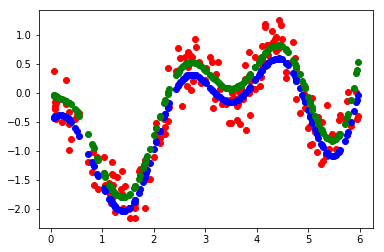

In [128]:
plt.plot(X,Y, 'ro')
plt.plot(X, f_25, 'bo')
plt.plot(X, f_975, 'go')

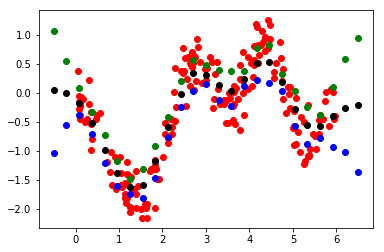

In [137]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, f_star_25, 'bo')
plt.plot(X_star, f_star_975, 'go')
plt.plot(X_star, f_star_median, 'ko')

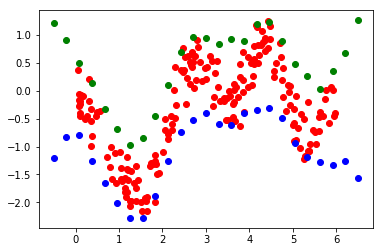

In [132]:
plt.plot(X,Y, 'ro')
plt.plot(X_star, y_star_25, 'bo')
plt.plot(X_star, y_star_975, 'go')

In [133]:
print("Mean difference for f between 2.5 and 97.5 percentile: %.3f"%np.mean(f_975/10 - f_25/10))

Mean difference for f between 2.5 and 97.5 percentile: 0.025


In [134]:
print("Mean difference for fstar between 2.5 and 97.5 percentile: %.3f"%np.mean(f_star_975/10 - f_star_25/10))

Mean difference for fstar between 2.5 and 97.5 percentile: 0.069


In [135]:
print("Mean difference for fstar between 2.5 and 97.5 percentile: %.3f"%np.mean(y_star_975 - y_star_25))

Mean difference for fstar between 2.5 and 97.5 percentile: 1.549


In [15]:
# print(fit_gpr_rff)

In [26]:
print(K_samples.shape)

NameError: name 'K_samples' is not defined

In [18]:
K_sample799 = K_samples[-100,:,:]

In [21]:
print(K_sample799.shape)
# print(K_sample799[10,7])

(200, 200)


In [138]:
print(X.shape)

(200, 1)


In [139]:
intervals = ((0.75,1.25), (2.5, 3.0), (4.25, 4.75))


In [140]:
X_train = X.copy()
Y_train = Y.copy()

In [141]:
X_test, Y_test = [], [] 

In [142]:
for low, up in intervals:
    ind = np.logical_and(X_train.flatten() > low, X_train.flatten() < up)
    X_test.append(X_train[ind])
    Y_test.append(Y_train[ind])
    X_train = np.delete(X_train, np.where(ind)[0], axis=0)
    Y_train = np.delete(Y_train, np.where(ind)[0], axis=0)
X_test, Y_test = np.vstack(X_test), np.vstack(Y_test)

In [143]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(200, 1)
(145, 1)
(55, 1)


In [144]:
gp_snelson_data_imputed = {'N':X_train.shape[0], 'x':X_train.flatten(), 'y':Y_train.flatten(), 'M':40, 'N_star':X_test.shape[0], 'x_star':X_test.flatten()}

In [145]:
fit_gpr_rff_imp = stan_model_rff.sampling(data=gp_snelson_data_imputed, iter=600, chains=2)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [146]:
samples_imp = fit_gpr_rff_imp.extract(permuted=True)

In [148]:
f_star = samples_imp['f_star']
y_star = samples_imp['y_star']

In [180]:
print(list(samples_imp.keys()))

['b1', 'b2', 'ps', 'bk', 'phase', 'sigma', 'f', 'feats', 'A', 'fullfeats', 'f_star', 'y_star', 'lp__']


In [185]:
sigma_samples_imp = samples_imp['sigma']
phase_samples_imp = samples_imp['phase']
amp1_samples_imp = samples_imp['b1']
amp2_samples_imp = samples_imp['b2']

In [151]:
pred_mean_f = np.mean(f_star, axis=0)
pred_var_f = np.var(f_star, axis=0)

In [163]:
pred_mean_y = np.mean(y_star, axis=0)
pred_var_y = np.var(y_star, axis=0)

In [164]:
print(pred_mean_y)
print(pred_var_y)

[-1.00184637 -0.80687816 -1.13142916 -1.10450187 -1.12302756 -1.13684701
 -1.11287987 -1.11534124 -0.87259429 -0.99417583 -0.8113098  -1.12221234
 -0.78603478 -1.15356312 -1.03289392 -0.87955199 -1.08226499 -0.99854659
 -1.00871432  0.08605813  0.0415796   0.07396708  0.04681247  0.09336365
 -0.05559117 -0.04014907  0.03359945  0.06056596  0.08673101 -0.04993464
  0.0210366   0.10252198  0.05642286  0.06955514  0.04007115  0.09615064
  0.0839099   0.06314679  0.07474946  0.06514627  0.12639984  0.2290913
  0.1850906   0.25254999  0.2156395   0.19142331  0.09290886  0.00438254
  0.06361427 -0.02263635  0.24208013  0.15639591  0.23559709  0.22357475
  0.23924346]
[0.24169857 0.23499734 0.28599427 0.27245748 0.2769338  0.30807127
 0.24686165 0.25936391 0.24480255 0.20419311 0.18792517 0.2893054
 0.22221239 0.32437922 0.29905483 0.23979181 0.24898386 0.24839911
 0.22941813 0.31488803 0.41309642 0.38400087 0.41942127 0.38558588
 0.36243454 0.46920784 0.30243276 0.43269473 0.39845906 0.42547

In [165]:
def RMSE(Y_star, Y_test):
    rmse = np.sqrt(np.mean(np.square(Y_star - Y_test)))
    return rmse

def NMSE(Y_star, Y_test):
    nmse = np.mean(np.square(Y_star - Y_test)) / np.mean(np.square(Y_test - np.mean(Y_test)))
    return nmse

def MLPPD(Y_star, Y_test, var_star):
    mlppd = 0.5* (np.sum(np.square(Y_star - Y_test)/var_star + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd
    

In [166]:
rmse = RMSE(pred_mean_y, Y_test)
print(rmse)

1.187474211699301


In [167]:
nmse = NMSE(pred_mean_y, Y_test)
print(nmse)

1.2834903369369308


In [168]:
mlppd = MLPPD(pred_mean_y, Y_test, pred_var_y)
print(mlppd)

151.01111244575952


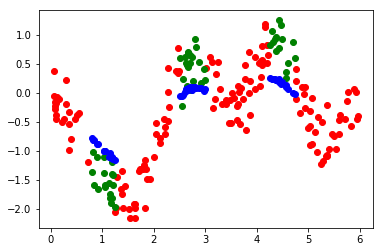

In [159]:
plt.plot(X_train,Y_train, 'ro')
plt.plot(X_test,Y_test, 'go')
plt.plot(X_test, pred_mean_y, 'bo')

(0.059167804, 5.9657729)

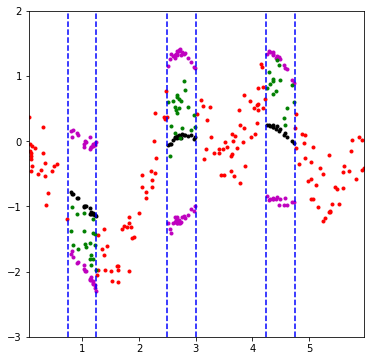

In [196]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), sharex=True)
ax.plot(X_test, pred_mean_y + 2*np.sqrt(pred_var_y), 'm.')
ax.plot(X_test, pred_mean_y - 2*np.sqrt(pred_var_y), 'm.')
ax.plot(X_test, pred_mean_y, 'k.')
ax.plot(X_train, Y_train, 'r.')
ax.plot(X_test, Y_test, 'g.')
for i in intervals:
    ax.plot([i[0], i[0]], [-3, 2], 'b--')
    ax.plot([i[1], i[1]], [-3, 2], 'b--')
ax.set_ylim(-3, 2)
ax.set_xlim(X.min(), X.max())

In [189]:
print(phase_samples_imp.shape)
print(sigma_samples_imp.shape)
print(amp1_samples_imp.shape)

(600,)
(600,)
(600, 40)


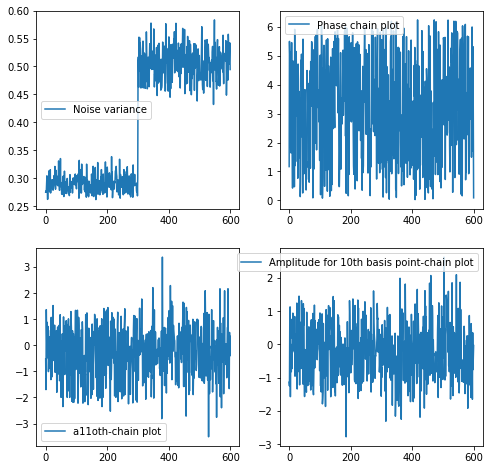

In [201]:
fig, axes = plt.subplots(2,2, figsize=(8,8))

axes[0,0].plot(sigma_samples_imp)
axes[0,0].legend(['Noise variance'])
axes[0,1].plot(phase_samples_imp)
axes[0,1].legend(['Phase chain plot'])
axes[1,0].plot(amp1_samples_imp[:,10])
axes[1,0].legend(['a11oth-chain plot'])
axes[1,1].plot(amp2_samples_imp[:,10])
axes[1,1].legend(['Amplitude for 10th basis point-chain plot'])

In [195]:
print(Y_test.flatten())
print(pred_mean_y)

[-1.6191998  -1.5898677  -1.4197883  -1.1922887  -1.4049308  -1.5914154
 -1.5560383  -1.9023357  -1.1101869  -1.3804133  -1.011783   -1.8111369
 -1.3704895  -1.9706934  -1.8112513  -1.6510072  -1.7473682  -1.5803886
 -1.103029    0.17028679  0.62081363  0.43530999  0.70563809  0.91757352
  0.60504345  0.23281771  0.40492375  0.6795046   0.79069173 -0.23416586
  0.61823724  0.20157393  0.52015974  0.21889455  0.12356613  0.51426983
  0.04602774  0.47173193  0.52315895  0.6460294   0.24939631  1.2473979
  0.93191177  0.81436169  0.95155796  0.77289801  0.34881056  0.86707862
  0.50594554  0.60534989  0.91682906  1.1606214   0.87041691  0.72285343
  1.0657384 ]
[-1.00184637 -0.80687816 -1.13142916 -1.10450187 -1.12302756 -1.13684701
 -1.11287987 -1.11534124 -0.87259429 -0.99417583 -0.8113098  -1.12221234
 -0.78603478 -1.15356312 -1.03289392 -0.87955199 -1.08226499 -0.99854659
 -1.00871432  0.08605813  0.0415796   0.07396708  0.04681247  0.09336365
 -0.05559117 -0.04014907  0.03359945  0.0

In [202]:
RMSE_test = RMSE(pred_mean_y, Y_test)
NMSE_test = NMSE(pred_mean_y, Y_test)
MLPPD_test = MLPPD(pred_mean_y, Y_test, pred_var_y)
# print(" Full GP RBF kernel- RMSE train error: %.3f"%RMSE_train)
print(" Full GP RBF kernel HMC Sampling- RMSE test error: %.3f"%RMSE_test)
# print(" Full GP RBF kernel- NMSE train error: %.3f"%NMSE_train)
print(" Full GP RBF kernel HMC sampling- NMSE test error: %.3f"%NMSE_test)
# print(" Full GP RBF kernel- MLPPD train error: %.3f"%MLPPD_train)
print(" Full GP RBF kernel HMC sampling- MLPPD test error: %.3f"%MLPPD_test)

 Full GP RBF kernel HMC Sampling- RMSE test error: 1.187
 Full GP RBF kernel HMC sampling- NMSE test error: 1.283
 Full GP RBF kernel HMC sampling- MLPPD test error: 151.011
